In [2]:
#MODULE IMPORTATION AND ENVIRONMENT CONFIGURATION
import re
import unicodedata
import pickle
import warnings

from time import time
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contractions
import inflect

from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict

from nltk import pos_tag
from nltk import punkt
from nltk.corpus import stopwords, wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.utils import shuffle
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

from utility_ML import *

##### UNCOMMENT THIS SECTION ON FIRST EXECUTION
# import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')
#####

np.random.seed(500) #set seed for random results base calculation
plt.style.use('fivethirtyeight') #choose fivethirtyeight style for plt
warnings.filterwarnings('ignore', category=FutureWarning) #filter FutureWarnings

In [3]:
#IMPORTATION OF DATASETS
#importation of opinion dataset
df_avis = import_dataset(DATA_PATH, importation_message="\nDataframe des avis", sep='\t', names=['Avis'])

#importation of scores dataset
df_score = import_dataset(TARGET_PATH, importation_message='\nDataframe des scores', sep='\t', names=['Score'])

#merging of both datasets
df = merge_datasets(df_avis, df_score)

#shuffling of the merged dataset
df = shuffle_dataset(df)



Dataframe des avis
Size : (10000, 1)
Head of imported dataset :


,Avis
0,Obviously made to show famous 1950s stripper M...
1,This film was more effective in persuading me ...
2,Unless you are already familiar with the pop s...
3,From around the time Europe began fighting Wor...
4,Im not surprised that even cowgirls get the bl...




Dataframe des scores
Size : (10000, 1)
Head of imported dataset :


,Score
0,-1
1,-1
2,-1
3,-1
4,-1


Size : (10000, 2)
Head of merged dataset :


,Avis,Score
0,Obviously made to show famous 1950s stripper M...,-1
1,This film was more effective in persuading me ...,-1
2,Unless you are already familiar with the pop s...,-1
3,From around the time Europe began fighting Wor...,-1
4,Im not surprised that even cowgirls get the bl...,-1


Head of shuffled dataset :


,Avis,Score
0,After having read two or three negative review...,1
1,I recently (May 2008) discovered that this chi...,1
2,"Pathetic is the word. Bad acting, pathetic scr...",-1
3,Spencer Tracy and Katherine Hepburn would roll...,-1
4,This in my opinion is one of the best action m...,1


In [4]:
#PREPROCESSING DATASET
df_transformed = df.copy() #creating a new copy of the dataset that will be preprocessed
df_transformed['Avis'] = preprocess_dataset(df_transformed['Avis']) #preprocessing of opinions column
display(df_transformed['Avis'].head())

0    read two three negative review main page imdb ...
1    recently may two thousand and eight discover c...
2    pathetic word bad act pathetic cheezy dialog h...
3    spencer tracy katherine hepburn would roll gra...
4    opinion one best action 1970s not feature grea...
Name: Avis, dtype: object

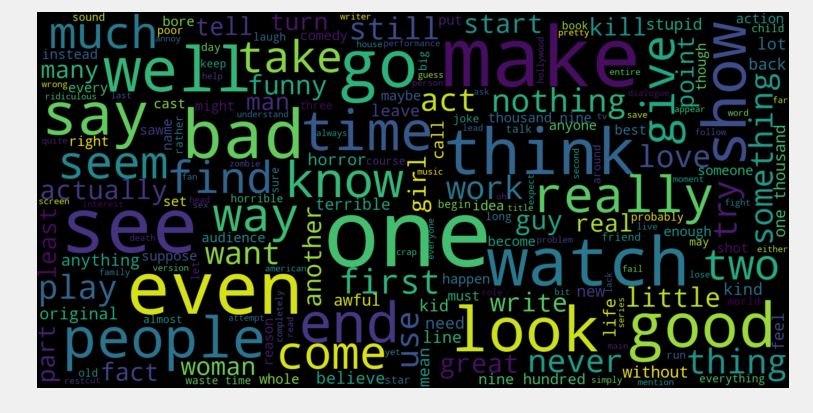

In [5]:
#VISUALIZING MOST FREQUENT WORD IN NEGATIVE OPINIONS
neg_avis = df_transformed[df_transformed['Score']==-1]
neg_avis = [document for document in neg_avis['Avis']]
neg_avis = pd.Series(neg_avis).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_avis)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

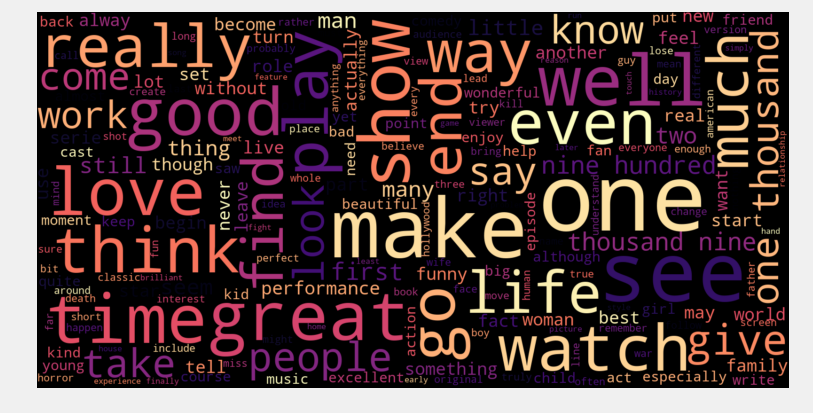

In [6]:
#VISUALIZING MOST FREQUENT WORD IN POSITIVE OPINIONS
pos_avis = df_transformed[df_transformed['Score']==1]
pos_avis = [document for document in pos_avis['Avis']]
pos_avis = pd.Series(pos_avis).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200, colormap='magma').generate(pos_avis)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [7]:
#VECTORIZING

#splitting the dataset prior to vectorization, to prevent memory related errors during processing
df_first_partition = df_transformed.iloc[:5000]
df_second_partition = df_transformed.iloc[5000:]

#vectorization of the opinions column
vectorizer = TfidfVectorizer(min_df=12, ngram_range=(1,2))
vectors = vectorizer.fit_transform(df_first_partition['Avis'])

In [9]:
#CROSS VALIDATION USING ACCURACY METRIC

#choosing the data (opinions) and target (score) columns in the dataset
X = vectors.toarray()
y = df_first_partition['Score']

#dictionary containing the models to cross validate using their default parameters
models = {
    'LogisticRegression': LogisticRegression(),
    #'DecisionTreeClassifier': DecisionTreeClassifier(),
    #'RandomForestClassifier': RandomForestClassifier(),
    'GaussianNB': GaussianNB(),
    #'KNeighborsClassifier': KNeighborsClassifier(),
    #'SVC': SVC(),
    'LinearSVC': LinearSVC()
}

#configuring the parameters used by the cross validation function
k_fold = KFold(n_splits=10, shuffle=True, random_state=CV_SEED)

#cross validation using accuracy metric
#for each defined model
for name, model in models.items():
    start_time = time()
    print('Cross validation started at {}'.format(datetime.now()))
    cv_score = cross_val_score(model, X, y, cv=k_fold, scoring=CV_SCORING)
    output = """
    Time taken to complete cross validation of {}: {} seconds
    Accuracy scores over 10 evaluations: {}
    Mean score: {}
    Standard deviation of scores: {}
    """.format(name, time() - start_time, cv_score, cv_score.mean(), cv_score.std())
    print(output)

Cross validation started at 2019-04-17 21:04:51.287551

    Time taken to complete cross validation of LogisticRegression: 2.075960397720337 seconds
    Accuracy scores over 10 evaluations: [0.914 0.898 0.9   0.91  0.892 0.936 0.91  0.902 0.912 0.916]
    Mean score: 0.9090000000000001
    Standard deviation of scores: 0.011636150566231095
    
Cross validation started at 2019-04-17 21:04:53.364128

    Time taken to complete cross validation of GaussianNB: 6.236785650253296 seconds
    Accuracy scores over 10 evaluations: [0.852 0.798 0.846 0.824 0.852 0.85  0.828 0.842 0.798 0.832]
    Mean score: 0.8322
    Standard deviation of scores: 0.01952331938989882
    
Cross validation started at 2019-04-17 21:04:59.601234

    Time taken to complete cross validation of LinearSVC: 1.978975772857666 seconds
    Accuracy scores over 10 evaluations: [0.932 0.89  0.896 0.926 0.904 0.934 0.908 0.918 0.908 0.904]
    Mean score: 0.9119999999999999
    Standard deviation of scores: 0.0141985914794

In [44]:
#RESULTS OF THE CROSS VALIDATION ON BOTH PARTITIONS

#FIRST PARTITION [0:5000]
########################
# Cross validation started at 2019-04-12 13:56:55.212174
# 
#     Time taken to complete cross validation of LogisticRegression: 7.469494581222534 seconds
#     Accuracy scores over 10 evaluations: [0.908 0.89  0.894 0.9   0.884 0.916 0.892 0.91  0.906 0.886]
#     Mean score: 0.8986000000000001
#     Standard deviation of scores: 0.01043264108459599
# 
# Cross validation started at 2019-04-12 13:57:02.682150
# 
#     Time taken to complete cross validation of SGDClassifier: 16.67750573158264 seconds
#     Accuracy scores over 10 evaluations: [0.916 0.88  0.854 0.858 0.85  0.916 0.812 0.912 0.908 0.812]
#     Mean score: 0.8718
#     Standard deviation of scores: 0.038775765627515335
#
# Cross validation started at 2019-04-12 14:07:25.906064
# 
#     Time taken to complete cross validation of DecisionTreeClassifier: 443.644727230072 seconds
#     Accuracy scores over 10 evaluations: [0.758 0.722 0.754 0.728 0.734 0.78  0.726 0.742 0.736 0.75 ]
#     Mean score: 0.743
#     Standard deviation of scores: 0.016881943016134146
#
# Cross validation started at 2019-04-12 14:14:49.551167
# 
#     Time taken to complete cross validation of RandomForestClassifier: 44.67994499206543 seconds
#     Accuracy scores over 10 evaluations: [0.77  0.778 0.774 0.766 0.79  0.784 0.804 0.764 0.78  0.772]
#     Mean score: 0.7782000000000001
#     Standard deviation of scores: 0.011469960767151744
# 
# Cross validation started at 2019-04-12 14:00:25.789652
# 
#     Time taken to complete cross validation of GaussianNB: 28.69598889350891 seconds
#     Accuracy scores over 10 evaluations: [0.676 0.642 0.69  0.68  0.638 0.7   0.66  0.682 0.68  0.672]
#     Mean score: 0.6719999999999999
#     Standard deviation of scores: 0.018846750383023584
# 
# Cross validation started at 2019-04-12 14:35:25.204313
# 
#     Time taken to complete cross validation of KNeighborsClassifier: 1241.7990498542786 seconds
#     Accuracy scores over 10 evaluations: [0.794 0.782 0.782 0.804 0.764 0.788 0.806 0.824 0.776 0.796]
#     Mean score: 0.7916
#     Standard deviation of scores: 0.01624315240339756
# 
# Cross validation started at 2019-04-12 14:56:07.003706
# 
#     Time taken to complete cross validation of LinearSVC: 7.24153470993042 seconds
#     Accuracy scores over 10 evaluations: [0.916 0.888 0.902 0.91  0.902 0.932 0.904 0.91  0.912 0.902]
#     Mean score: 0.9077999999999999
#     Standard deviation of scores: 0.010897706180660232

#SECOND PARTITION [5000:10000]
##############################
# Cross validation started at 2019-04-12 13:58:46.938275
# 
#     Time taken to complete cross validation of LogisticRegression: 7.57363748550415 seconds
#     Accuracy scores over 10 evaluations: [0.902 0.912 0.894 0.912 0.894 0.89  0.904 0.912 0.908 0.892]
#     Mean score: 0.9019999999999999
#     Standard deviation of scores: 0.008438009243891603
# 
# Cross validation started at 2019-04-12 13:58:54.512393
# 
#     Time taken to complete cross validation of SGDClassifier: 16.909173488616943 seconds
#     Accuracy scores over 10 evaluations: [0.924 0.91  0.848 0.882 0.89  0.9   0.882 0.91  0.922 0.9  ]
#     Mean score: 0.8968
#     Standard deviation of scores: 0.021469979040511445
#
# Cross validation started at 2019-04-12 14:18:27.835834
# 
#     Time taken to complete cross validation of DecisionTreeClassifier: 453.8783338069916 seconds
#     Accuracy scores over 10 evaluations: [0.706 0.712 0.696 0.77  0.718 0.74  0.74  0.76  0.706 0.736]
#     Mean score: 0.7283999999999999
#     Standard deviation of scores: 0.02342306555513178
# 
# Cross validation started at 2019-04-12 14:26:01.714540
# 
#     Time taken to complete cross validation of RandomForestClassifier: 46.442110776901245 seconds
#     Accuracy scores over 10 evaluations: [0.75  0.796 0.8   0.764 0.764 0.756 0.772 0.776 0.808 0.738]
#     Mean score: 0.7724
#     Standard deviation of scores: 0.021666564102321366
#
# Cross validation started at 2019-04-12 14:04:24.184877
# 
#     Time taken to complete cross validation of GaussianNB: 29.050445556640625 seconds
#     Accuracy scores over 10 evaluations: [0.68  0.684 0.648 0.698 0.688 0.67  0.704 0.662 0.664 0.664]
#     Mean score: 0.6761999999999999
#     Standard deviation of scores: 0.016720047846821465
#
# Cross validation started at 2019-04-12 15:00:11.372601
# 
#     Time taken to complete cross validation of KNeighborsClassifier: 1274.044404745102 seconds
#     Accuracy scores over 10 evaluations: [0.784 0.78  0.776 0.82  0.754 0.774 0.772 0.782 0.81  0.768]
#     Mean score: 0.7819999999999999
#     Standard deviation of scores: 0.018482424083436668
# 
# Cross validation started at 2019-04-12 15:21:25.417337
# 
#     Time taken to complete cross validation of LinearSVC: 7.582218647003174 seconds
#     Accuracy scores over 10 evaluations: [0.916 0.928 0.912 0.916 0.898 0.908 0.898 0.908 0.928 0.896]
#     Mean score: 0.9108000000000003
#     Standard deviation of scores: 0.010998181667894026

In [10]:
#GRIDSEARCH USING THE ACCURACY METRIC FOR PARAMETERS TUNING

#based on the cross-validation results, using KFold over 10 partitions
#the models LogisticRegression and LinearSVC are best suited for the job
#However, using GaussianNB should also be taken into account, since it's among the most adapted
#for sentiment analysis

#dictionary containing the candidate models that will be used 
#for parameters tuning using a GridSearchCV
candidates = {
    'LogisticRegression': models['LogisticRegression'],
    'LinearSVC': models['LinearSVC']
}

#dictionary of the hyperparameters to be tuned for each model
grid_params = {
    'LogisticRegression': [
        {'C': np.logspace(-4,4,20)},
        {'penalty': ['l1','l2']}
    ],
    'LinearSVC': [
        {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
    ]
}

#generation of training/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = TTS_VALIDATION_SIZE,
    test_size = TTS_TEST_SIZE,
    random_state = TTS_SEED
)

#GridSearchCV for every candidate classifier
grid_search_results = []
for name, model in candidates.items():
    #creation of the gridsearch
    grd_sr = GridSearchCV(
        estimator = model,
        param_grid = grid_params[name],
        scoring = GRDSR_SCORING,
        cv = 5,
        n_jobs = -1,
        iid = True,
        return_train_score = True
    )
    
    #execution of the gridsearch
    start_time = time()
    print('Grid search started at {}'.format(datetime.now()))
    grd_sr.fit(X_train, y_train)
    print('\nTime taken to complete Grid search of {}: {} seconds'.format(name, time() - start_time))
    grd_sr_result = GridSearchResult(name, grd_sr.best_score_, grd_sr.best_estimator_)
    print(grd_sr_result)
    grid_search_results.append(grd_sr_result)

#sorting the results by descending order on the score column of the GridSearchResult objects
grid_search_results = sorted(grid_search_results, key=lambda result: result.score, reverse=True)

print('The best model with the best hyperparameters:\n{}'.format(grid_search_results[0]))

Grid search started at 2019-04-17 21:13:14.697916

Time taken to complete Grid search of LogisticRegression: 12.996025800704956 seconds

        Model: LogisticRegression
        Best Accuracy Score: 0.8826666666666667
        Best Estimator: LogisticRegression(C=11.288378916846883, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
        
Grid search started at 2019-04-17 21:13:27.694365

Time taken to complete Grid search of LinearSVC: 3.8341774940490723 seconds

        Model: LinearSVC
        Best Accuracy Score: 0.8806666666666667
        Best Estimator: LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
        
The best model with th

In [11]:
#PIPELINE CREATION FOR GAUSSIANNB CLASSIFIER
#creating the pipeline instance
gnb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=preprocess, min_df=12, ngram_range=(1, 2))),
    ('to_dense', DenseTransformer()),
    ('clf', GaussianNB())
])

#choosing data and target columns from initial dataset
df_pipeline = df
X = df_pipeline['Avis']
y = df_pipeline['Score']

#generating the training/test sets from the initial dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = TTS_VALIDATION_SIZE,
    test_size = TTS_TEST_SIZE,
    random_state = TTS_SEED
)

#learning the model using the pipeline
start_time = time()
print('GaussianNB classifier pipeline execution started at {}'.format(datetime.now()))
gnb_pipeline.fit(X_train, y_train)
print('\nTime taken to complete pipeline execution: {} seconds'.format(time() - start_time))

#predicting the targets of test data
start_time = time()
print('\nGaussianNB classifier prediction started at {}'.format(datetime.now()))
prediction_result = gnb_pipeline.predict(X_test)
print('\nTime taken to complete prediction: {} seconds'.format(time() - start_time))

#printing the accuracy, confusion matrix and classification report
#of the classifier in the pipeline
accuracy = accuracy_score(prediction_result, y_test)
conf = confusion_matrix(y_test, prediction_result)
report = classification_report(y_test, prediction_result)
print('''
Accuracy: {}
Confusion Matrix
{}

Classification Report
{}
'''.format(accuracy, conf, report))

GaussianNB classifier pipeline execution started at 2019-04-17 21:19:08.298335

Time taken to complete pipeline execution: 31.35653257369995 seconds

GaussianNB classifier prediction started at 2019-04-17 21:19:39.654950

Time taken to complete prediction: 72.62863898277283 seconds

Accuracy: 0.8272857142857143
Confusion Matrix
[[2814  669]
 [ 540 2977]]

Classification Report
              precision    recall  f1-score   support

          -1       0.84      0.81      0.82      3483
           1       0.82      0.85      0.83      3517

   micro avg       0.83      0.83      0.83      7000
   macro avg       0.83      0.83      0.83      7000
weighted avg       0.83      0.83      0.83      7000




In [12]:
#SAVING GAUSSIANNB PIPELINE
print('Saving the Gaussian Naive Bayes pipeline')
pickle.dump(gnb_pipeline, open(GAUSSIANNB_PATH, 'wb'))

Saving the Gaussian Naive Bayes pipeline


In [14]:
#PIPELINE CREATION FOR LOGISTICREGRESSION CLASSIFIER
#creating the pipeline instance
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=preprocess, min_df=12, ngram_range=(1, 2))),
    ('to_dense', DenseTransformer()),
    ('clf', grid_search_results[0].estimator)
])

#choosing data and target columns from initial dataset
X = df['Avis']
y = df['Score']

#generating the training/test sets from the initial dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = TTS_VALIDATION_SIZE,
    test_size = TTS_TEST_SIZE,
    random_state = TTS_SEED
)

#learning the model using the pipeline
start_time = time()
print('LogisticRegression classifier pipeline execution started at {}'.format(datetime.now()))
lr_pipeline.fit(X_train, y_train)
print('\nTime taken to complete pipeline execution: {} seconds'.format(time() - start_time))

#predicting the targets of test data
start_time = time()
print('\nLogisticRegression classifier prediction started at {}'.format(datetime.now()))
prediction_result = lr_pipeline.predict(X_test)
print('\nTime taken to complete prediction: {} seconds'.format(time() - start_time))

#accuracy, confusion matrix and classification report of the classifier
accuracy = accuracy_score(prediction_result, y_test)
conf = confusion_matrix(y_test, prediction_result)
report = classification_report(y_test, prediction_result)
print('''
Accuracy: {}
Confusion Matrix
{}

Classification Report
{}
'''.format(accuracy, conf, report))

LogisticRegression classifier pipeline execution started at 2019-04-17 21:24:44.341586

Time taken to complete pipeline execution: 33.958030700683594 seconds

LogisticRegression classifier prediction started at 2019-04-17 21:25:18.300160

Time taken to complete prediction: 74.90363955497742 seconds

Accuracy: 0.8995714285714286
Confusion Matrix
[[3110  373]
 [ 330 3187]]

Classification Report
              precision    recall  f1-score   support

          -1       0.90      0.89      0.90      3483
           1       0.90      0.91      0.90      3517

   micro avg       0.90      0.90      0.90      7000
   macro avg       0.90      0.90      0.90      7000
weighted avg       0.90      0.90      0.90      7000




In [15]:
#SAVING LOGISTICREGRESSION PIPELINE
print('Saving the Logistic Regression pipeline')
pickle.dump(lr_pipeline, open(LOGISTICREGRESSION_PATH, 'wb'))

Saving the Logistic Regression pipeline
